In [29]:
import os
import numpy as np
import h5py
import json
import torch
from tqdm import tqdm
from collections import Counter
import random as random
from PIL import Image 
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision as tv
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform
from nltk.translate.bleu_score import corpus_bleu
from torch.nn.utils.rnn import pack_padded_sequence

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [31]:
karpathy_json_path = 'data/dataset_flickr8k.json'
MAX_LENGTH = 50

In [32]:
#get the training splits across all data set 
with open(karpathy_json_path, 'r') as j:
        flickr8k_datasplit = json.load(j)

In [33]:
for key in flickr8k_datasplit:
    print(key)

images
dataset


In [34]:

image_folder = 'data/Flicker8k_Dataset'

In [35]:
def get_train_val_test_splits(image_folder, image_splits, max_caption_len, min_word_freq):
    '''
        method will return three lists containing the training, validation, and testing 
        file paths and captions. Method will also return the word map that will be used for captioning
        images. 
        Parameters: 
            image_folder: location of the images in the data set, either MSCOCO, Flickr8K, Flickr30k 
            
            image_splits: dictionary that contains the captions for each image and indicates whether 
            image part of training, validation, or testing set
            
            max_caption_len: threshold for maximum caption length 
            
            min_word_freq: threshold that determines whether a word will be in word map or not. 
            
            
        Output:
            train_img_caps: list of tuples containing the training image file path and caption
            val_img_caps: list of tuples containing the validation image file path and caption
            test_img_caps: list of tuples containing the testing image file path and caption
        '''
    #storing tuple of path to img and the caption
    word_freq = Counter()
    train_img_caps = []
    val_img_caps = []
    test_img_caps = [] 
    num_train_img, num_val_img, num_test_img = 0, 0, 0 
    for img in image_splits['images']:
        img_captions = []
        for word in img['sentences']:
            #check if the caption length is not to long
            if len(word['tokens']) <= max_caption_len:
                img_captions.append(word['tokens'])
            # Update word frequency
            word_freq.update(word['tokens'])

        #if caption is of length zero move to next image 
        if not len(img_captions): 
            continue 

        img_file_path = os.path.join(image_folder, img['filename'])
        #save corresponding files and captions 
        if img['split'] == 'train':
            train_img_caps.append((img_file_path, img_captions))
            num_train_img+=1
        elif img['split'] == 'val':
            val_img_caps.append((img_file_path, img_captions))
            num_val_img+=1 
        elif img['split'] == 'test':
            test_img_caps.append((img_file_path, img_captions))
            num_test_img+=1
    
    #create a limited vocabulary and don't include any word that hasn't appeared 
    #min_word_freq times
    words = [w for w in word_freq if word_freq[w] >= min_word_freq]
    min_words = [w for w in word_freq if word_freq[w] < min_word_freq]
    word_map = {word: i+1 for i, word in enumerate(words)}
    #specify start token, end token, unknown token, and padding token 
    word_map['<START>'] = len(word_map) + 1 
    word_map['<END>'] = len(word_map) + 1
    word_map['<UNK>'] = len(word_map) + 1
    word_map['<PAD>'] = 0
    
    print("Number of training images: {0}".format(num_train_img))
    print("Number of validation images: {0}".format(num_val_img))
    print("Number of testing images: {0}".format(num_test_img))
    return train_img_caps, val_img_caps, test_img_caps, word_map

In [36]:
train_data, val_data, test_data, word_map = get_train_val_test_splits(image_folder, flickr8k_datasplit, 50, 5)

Number of training images: 6000
Number of validation images: 1000
Number of testing images: 1000


In [ ]:
def create_dataset(data, split, word_map, base_file_name, captions_per_image):
    output_folder = 'data/'
    encoded_captions = []
    encoded_captions_length = []
    start_token = word_map['<START>']
    end_token = word_map['<END>']
    unknown_token = word_map['<UNK>']
    padding_token = word_map['<PAD>']
    training_data_file = os.path.join(output_folder, base_file_name + '_' + split + '_images.hdf5')
    encoded_captions_file = os.path.join(output_folder, base_file_name + '_' + split + '_encoded_captions.json')
    encoded_captions_length_file = os.path.join(output_folder, base_file_name + '_' + split + '_encoded_caption_lengths.json')
    
    print("Creating %s data set" % split)
    with h5py.File(os.path.join(output_folder, base_file_name + '_' + split + '_images' + '.hdf5'), 'a') as h:
        images = h.create_dataset('images', (len(data), 3, 256, 256), dtype='uint8')
        for image_idx ,(image_path, image_captions) in enumerate(data):
            
            #want to ensure that there are at least certain number of captions per image 
            #if current image has less than that threshold, then augement the captions
            num_captions = len(image_captions)
            if num_captions < captions_per_image: 
                chosen_captions = [random.choice(image_captions) for _ in range(captions_pe_image - num_captions)]
                chosen_captions += image_captions
            else:
                chosen_captions = random.sample(image_captions, k = captions_per_image)
            
            #for the chosen captions, encode them
            
            for i, caption in enumerate(chosen_captions):
#                 import pdb; pdb.set_trace()
                encoded_caption = [word_map.get(w,unknown_token) for w in caption]
                assert len(caption) == len(encoded_caption)
                padding_for_caption = [padding_token for _ in range(MAX_LENGTH- len(caption))]
                encoded_caption = [start_token] + encoded_caption + [end_token] + padding_for_caption
                
                encoded_captions.append(encoded_caption)
                

                assert len(encoded_caption) == MAX_LENGTH + 2 
                encoded_captions_length.append(len(caption) + 2)
            
            #resize all images to be 256 x 256 
            image = Image.open(image_path)
            image_resize = image.resize((256, 256))
            image_array = np.asarray(image_resize).transpose(2,0,1) #ensures that 3x256x256
            images[image_idx] = image_array
            
            
            assert len(image_array.shape) == 3
            
        h.attrs['cpi'] = captions_per_image 
        
        print("Saving the encoded captions")
        #save the encoded captions and the encoded caption lengths to a json file 
        with open(encoded_captions_file, 'w') as j:
            json.dump(encoded_captions, j)

        with open(encoded_captions_length_file, 'w') as j:
            json.dump(encoded_captions_length, j)
        
        print("Done creating the dataset for split ")

In [ ]:
create_dataset(train_data, 'train', word_map, 'flickr8k', 5)

In [ ]:
create_dataset(val_data, 'val', word_map, 'flickr8k', 5)

In [41]:
create_dataset(test_data, 'test', word_map, 'flickr8k', 5)

Creating test data set
Saving the encoded captions
Done creating the dataset for split 


In [318]:
class MyDataset(Dataset):
    def __init__(self, folder, name, split, transform=None):
        '''
            Create a data set class that will be used when passing into the data loader. 
        '''
        self.split = split
        
        self.file = h5py.File(os.path.join(folder, name + '_' + self.split + '_images.hdf5'))
        self.images = self.file['images']
        
        self.cpi = self.file.attrs['cpi']
        
        # load captions
        with open(os.path.join(folder, name + '_' + self.split + '_encoded_captions.json'), 'r') as f:
            self.captions = json.load(f)
            
        # load captions' lenghts
        with open(os.path.join(folder, name + '_' + self.split + '_encoded_caption_lengths.json'), 'r') as f:
            self.lengths = json.load(f)
        
                        
    def __getitem__(self, idx):
        image = torch.FloatTensor(self.images[idx // self.cpi] / 255.0)
        original_image = self.images[idx // self.cpi]
#         trans = transforms.ToPILImage(mode='RGB')

        #TODO: not using standard formulation of mean=0, std=1
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
        image = normalize(image)
        
        caption, caption_length = torch.LongTensor(self.captions[idx]), torch.LongTensor([self.lengths[idx]])
        
        if self.split == 'train':
            return image, caption, caption_length
        else:
            start = self.cpi * (idx // self.cpi)
            end = start + self.cpi
            
            captions = torch.LongTensor(self.captions[start:end])
            
            
            return image, caption, caption_length, captions, original_image
    
    def __len__(self):
        return len(self.captions)
        

In [319]:
train_set = MyDataset('data', 'flickr8k', 'train')
val_set = MyDataset('data', 'flickr8k', 'val')
test_set = MyDataset('data', 'flickr8k', 'test')

train_loader = torch.utils.data.DataLoader(train_set, batch_size=16,shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=True, pin_memory=True)

In [68]:
class Encoder(nn.Module):
    def __init__(self, dim_size=14):
        super(Encoder, self).__init__()
        resnet = tv.models.resnet101(pretrained=True)

        modules = list(resnet.children())[:-2]

        self.resnet = nn.Sequential(*modules)

        self.pool = nn.AdaptiveAvgPool2d((dim_size, dim_size))
        
        #TODO: decided not to fine tune blocks 2-4
        
    def forward(self, images):
        # [batch_size, encoded_dim_size, encoded_dim_size, 2048]
        return self.pool(self.resnet(images)).permute(0, 2, 3, 1) 

    
class Attention(nn.Module):
    def __init__(self, dim_encoder, dim_decoder, dim_attention):
        super(Attention, self).__init__()
        
        self.attention_encoder = nn.Linear(dim_encoder, dim_attention)
        self.attention_decoder = nn.Linear(dim_decoder, dim_attention)
        self.both = nn.Linear(dim_attention, 1)
    
    def forward(self, out_encoder, hidden_decoder):
        attention_encoder = self.attention_encoder(out_encoder)
        attention_decoder = self.attention_decoder(hidden_decoder)
        
        weights = self.both(torch.relu(attention_encoder + attention_decoder.unsqueeze(1))).squeeze(2)
        weights = torch.softmax(weights, dim=1)
        
        out = torch.sum((out_encoder * weights.unsqueeze(2)), dim=1)
        
        return out, weights 

class Decoder(nn.Module):
    def __init__(self, dim_attention, dim_embed, dim_decoder, vocab_size, dim_encoder=2048):
        super(Decoder, self).__init__()
        
        self.dim_encoder = dim_encoder
        self.dim_attention = dim_attention
        self.dim_embed = dim_embed
        self.vocab_size = vocab_size
        
        self.attention = Attention(dim_encoder, dim_decoder, dim_attention)
        self.embed = nn.Embedding(vocab_size, dim_embed)
        self.drop = nn.Dropout(p=0.5)
        
        self.decode_lstm = nn.LSTMCell(dim_embed + dim_encoder, dim_decoder, bias=True)
        self.h_init = nn.Linear(dim_encoder, dim_decoder)
        self.c_init = nn.Linear(dim_encoder, dim_decoder)
        self.f = nn.Linear(dim_decoder, dim_encoder)
        
        self.fc1 = nn.Linear(dim_decoder, vocab_size)
        
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.fc1.bias.data.fill_(0)
        self.fc1.weight.data.uniform_(-0.1, 0.1)
        
    def init_hidden(self, out_encoder):
        out = out_encoder.mean(dim=1)
        
        return self.h_init(out), self.c_init(out)
    
    def forward(self, out_encoder, captions, lengths):
        batch_size = out_encoder.size(0)
        dim_encoder = out_encoder.size(-1)
        vocab_size = self.vocab_size
        
        out_encoder = out_encoder.view(batch_size, -1, dim_encoder)
        pixels = out_encoder.size(1)
        
        lengths, ind = lengths.squeeze(1).sort(dim=0, descending=True)
        out_encoder = out_encoder[ind]
        captions = captions[ind]
        
        embed = self.embed(captions)
        
        # init hidden state
        h, c = self.init_hidden(out_encoder)
        
        lengths = (lengths-1).tolist()
        
        predict = torch.zeros(batch_size, max(lengths), vocab_size).to(device)
        weights = torch.zeros(batch_size, max(lengths), pixels).to(device)
        
        for time_step in range(max(lengths)):
            batch_t = sum([i > time_step for i in lengths])
            
            weighted_encoder, alpha = self.attention(out_encoder[:batch_t], h[:batch_t])
            
            sig = torch.sigmoid(self.f(h[:batch_t]))
            weighted_encoder = sig * weighted_encoder
            
            h, c = self.decode_lstm(torch.cat([embed[:batch_t, time_step, :], weighted_encoder], dim=1),
                                    (h[:batch_t], c[:batch_t]))
            
            output = self.fc1(self.drop(h))
            predict[:batch_t, time_step, :] = output
            weights[:batch_t, time_step, :] = alpha
            
        return predict, captions, lengths, weights, ind
    
    def caption(self, encoded_img_features, word_map, beam_size=5):
        '''
            In this method, given the encoded image features, we will do beam 
            search to obtain the final captions for the image. 
        '''
        print(encoded_img_features.shape)
        
        enc_img_size, encoder_dimension = encoded_img_features.size(1), encoded_img_features.size(3)
        encoded_img_features = encoded_img_features.view(1, -1, encoder_dimension)
        total_pixels = encoded_img_features.size(1)
        
        encoded_img_features = encoded_img_features.expand(beam_size, total_pixels, encoder_dimension)
        
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        #initialize all sequences to only contain the start token at very beginning 
        captions =  torch.LongTensor([[word_map['<START>']]] * beam_size).to(device)

        prev_words = captions
        top_scores = torch.zeros(beam_size, 1).to(device)
        
        
        # alpha weights 
        soft_weights = torch.ones(beam_size, 1, enc_img_size, enc_img_size).to(device)
        
        completed_captions = []
        completed_captions_scores = []
        completed_captions_weights = []
        
        current_iter = 1 
        h,c = self.init_hidden(encoded_img_features)
        
        while True: 
#             import pdb; pdb.set_trace()
            embedding = self.embed(prev_words).squeeze(1)
            weighted_encoder, alpha = self.attention(encoded_img_features, h)
            
            sig = torch.sigmoid(self.f(h))
            weighted_encoder = sig * weighted_encoder
            
            h,c = self.decode_lstm(torch.cat((embedding, weighted_encoder), dim=1), (h,c))
            output = self.fc1(h)
            output = F.log_softmax(output, dim=1)
            
            output = top_scores.expand_as(output) + output 
            assert output.size(1) == len(word_map)
            
            if current_iter == 1: 
                top_scores, top_words = output[0].topk(beam_size, 0, True, True)
            else:
                top_scores, top_words = output.view(-1).topk(beam_size, 0, True, True)
            prev_word_idxs, next_word_idxs = top_words / output.size(1), top_words % output.size(1)
            
            
            captions = torch.cat((captions[prev_word_idxs], next_word_idxs.unsqueeze(1)), dim=1)
            
            
            alpha = alpha.view(-1, enc_img_size, enc_img_size)
            soft_weights = torch.cat((soft_weights[prev_word_idxs], alpha[prev_word_idxs].unsqueeze(1)), dim=1)

            incomplete_idx = [idx for idx, next_word in enumerate(next_word_idxs) if next_word != word_map['<END>']]
            complete_idx = list(set(range(len(next_word_idxs))) - set(incomplete_idx))
            
            if len(complete_idx):
                print("extending caption")
                completed_captions.extend(captions[complete_idx].tolist())
                completed_captions_scores.extend(top_scores[complete_idx])
                completed_captions_weights.extend(soft_weights[complete_idx].tolist())
            
            beam_size -= len(complete_idx)
            
            #done with beam search and can break
            if beam_size == 0: 
                print("finished beam search")
                break 
            
            captions = captions[incomplete_idx]
            soft_weights = soft_weights[incomplete_idx]
            h, c = h[prev_word_idxs[incomplete_idx]], c[prev_word_idxs[incomplete_idx]]
            encoded_img_features = encoded_img_features[prev_word_idxs[incomplete_idx]]
            top_scores = top_scores[incomplete_idx].unsqueeze(1)
            prev_words = next_word_idxs[incomplete_idx].unsqueeze(1)

            if current_iter > 50: 
                print("max iteration complete")
                break
            
            current_iter+=1 
        
        print(completed_captions_scores)
        
        best_seq_idx = completed_captions_scores.index(max(completed_captions_scores))
        chosen_caption, caption_weight = completed_captions[best_seq_idx], completed_captions_weights[best_seq_idx]
        
        
        return chosen_caption, caption_weight,   

In [63]:
encoder = Encoder().to(device)
decoder = Decoder(dim_attention=512, dim_embed=512, dim_decoder=512, vocab_size=len(word_map)).to(device)

In [351]:
def visualize_attention(image, original_image, decoder, encoder_image_features, smooth_weights = True):
    caption, weights = decoder.caption(encoder_image_features, word_map)
    idx2word = {v: k for k, v in word_map.items()}  

#     image = image.to('cpu')
#     image = image.squeeze(0).transpose(2,0)
        
    words = [idx2word[i] for i in caption]
    
    for i in range(len(words)):
        if (i>50):
            break
        
        plt.subplot(np.ceil(len(words)/5.), 5, (i+1))
        plt.text(0, 1, '%s' % (words[i]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(original_image)
                
        current_weight = weights[i]
        
        if smooth_weights:
            weight = skimage.transform.pyramid_expand(np.asarray(current_weight), upscale=24, sigma=8)
        else:
            weight = skimage.transform.resize(np.asarray(current_weight), [14*24, 14*24])        
        
        if(i==0):
            plt.imshow(weight, alpha=0)
        else:
            plt.imshow(weight, alpha=0.8)
        
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    
    plt.show()   

In [343]:
encoder_optimizer = torch.optim.Adam(params=encoder.parameters(), lr=1e-4)
decoder_optimizer = torch.optim.Adam(params=decoder.parameters(), lr=4e-4)

criterion = nn.CrossEntropyLoss().to(device)

In [352]:
from scipy.ndimage import rotate

image = val_set[0][0].unsqueeze(0).to(device)
original_image = rotate((val_set[0][4]).transpose(2,1,0), -90)
print(original_image.shape)

(256, 256, 3)


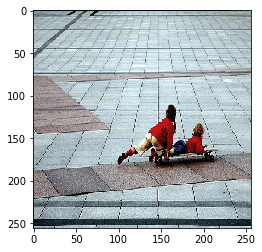

In [353]:
# plt.imshow(image.squeeze(0).to('cpu').transpose(2,0))
plt.imshow(original_image)

torch.Size([1, 14, 14, 2048])
finished beam search
[tensor(-13.4340, device='cuda:0', grad_fn=<SelectBackward>), tensor(-13.5133, device='cuda:0', grad_fn=<SelectBackward>), tensor(-13.5382, device='cuda:0', grad_fn=<SelectBackward>), tensor(-14.6641, device='cuda:0', grad_fn=<SelectBackward>), tensor(-14.6664, device='cuda:0', grad_fn=<SelectBackward>)]


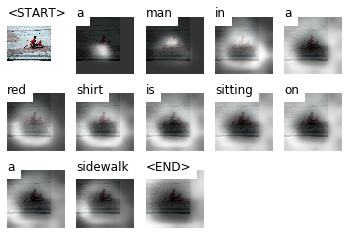

In [354]:
encoded_img = encoder(image)
visualize_attention(image, original_image, decoder, encoded_img)

In [58]:
def train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):
    decoder.train()
    encoder.train()
    
    loss_sum = 0
    loss_num = 0
    
    for i, (images, captions, lengths) in enumerate(train_loader):
        images = images.to(device)
        captions = captions.to(device)
        lengths = lengths.to(device)
        img_features = encoder(images)
        predict, captions, lengths, weights, ind = decoder(img_features, captions, lengths)
        targets = captions[:,1:]
        
        predict = pack_padded_sequence(predict, lengths, batch_first=True).data
        targets = pack_padded_sequence(targets, lengths, batch_first=True).data
        
        loss = criterion(predict, targets)
        
        loss += ((1. - weights.sum(dim=1)) ** 2).mean()
        
        decoder_optimizer.zero_grad()
#         encoder_optimizer.zero_grad()
        
        loss.backward()
        
        decoder_optimizer.step()
        
        loss_sum += loss.item()*sum(lengths)
        loss_num += sum(lengths)
        if i % 100 == 0: 
            print("Epoch % d [%d/%d], Loss: %f" % (epoch, i, len(train_loader), loss_sum/loss_num))

In [67]:
for epoch in range(1):
    train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch)
    bleu4 = validate(val_loader, encoder, decoder, criterion)

Epoch  0 [0/1875], Loss: 8.972549
Epoch  0 [100/1875], Loss: 6.275366
Epoch  0 [200/1875], Loss: 5.959714
Epoch  0 [300/1875], Loss: 5.738912
Epoch  0 [400/1875], Loss: 5.571746
Epoch  0 [500/1875], Loss: 5.437140
Epoch  0 [600/1875], Loss: 5.334302
Epoch  0 [700/1875], Loss: 5.246503
Epoch  0 [800/1875], Loss: 5.172333
Epoch  0 [900/1875], Loss: 5.113485
Epoch  0 [1000/1875], Loss: 5.060653
Epoch  0 [1100/1875], Loss: 5.009843
Epoch  0 [1200/1875], Loss: 4.967661
Epoch  0 [1300/1875], Loss: 4.927182
Epoch  0 [1400/1875], Loss: 4.888485
Epoch  0 [1500/1875], Loss: 4.854198
Epoch  0 [1600/1875], Loss: 4.823613
Epoch  0 [1700/1875], Loss: 4.793543
Epoch  0 [1800/1875], Loss: 4.763509
Validate [0/313], Loss: 3.978168
Validate [100/313], Loss: 4.147575
Validate [200/313], Loss: 4.161209
Validate [300/313], Loss: 4.165511
Validate. BLEU-4: 0.122190, Loss: 4.163710


In [ ]:
bleu4

In [ ]:
visualize_attention(decoder, )

In [59]:
def validate(val_loader, encoder, decoder, criterion):
    decoder.eval()
    encoder.eval()
    
    refs = []
    hypos = []
    
    loss_sum = 0
    loss_num = 0
    
    with torch.no_grad():
        for i, (images, captions, lengths, all_captions) in enumerate(val_loader):
            images = images.to(device)
            captions = captions.to(device)
            lengths = lengths.to(device)
            
            images = encoder(images)
            predict, captions, lengths, weights, ind = decoder(images, captions, lengths)
            
            targets = captions[:,1:]
            
            scores = predict.clone()
            
            predict = pack_padded_sequence(predict, lengths, batch_first=True).data
            targets = pack_padded_sequence(targets, lengths, batch_first=True).data
            
            loss = criterion(predict, targets)
            
            loss += ((1. - weights.sum(dim=1)) ** 2).mean()
                     
            loss_sum += loss.item()*sum(lengths)
            loss_num += sum(lengths)
                     
            if (i % 100) == 0:
                print("Validate [%d/%d], Loss: %f" % (i, len(val_loader), loss_sum/loss_num))
            
            all_captions = all_captions[ind]
            for j in range(all_captions.shape[0]):
                image_captions = all_captions[j].tolist()
                image_captions = list(map(lambda c : [w for w in c if w not in {word_map['<START>'], 
                                                                                word_map['<PAD>']}],
                                         image_captions))
                refs.append(image_captions)
            
            pred = torch.max(scores, dim=2)[1].tolist()
            temp = []
            for j, p in enumerate(pred):
                temp.append(pred[j][:lengths[j]])
            pred = temp
            hypos.extend(pred)
            
            assert len(refs) == len(hypos)
            
        bleu4 = corpus_bleu(refs, hypos)
        
        print("Validate. BLEU-4: %f, Loss: %f" % (bleu4, loss_sum/loss_num))
        
    return bleu4